# Training CNN for imaging fluid flow with streaks analysis
    

## Prepatory steps

Get some includes first and define convenience routines

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from numpy import random
import sys

%matplotlib inline

print(torch.__version__)

1.0.1.post2


Fix random seed to make sure we get reproducible results. This can be removed at production stage.

In [2]:
my_seed = 12345
torch.manual_seed(my_seed)

Load data and preprocess

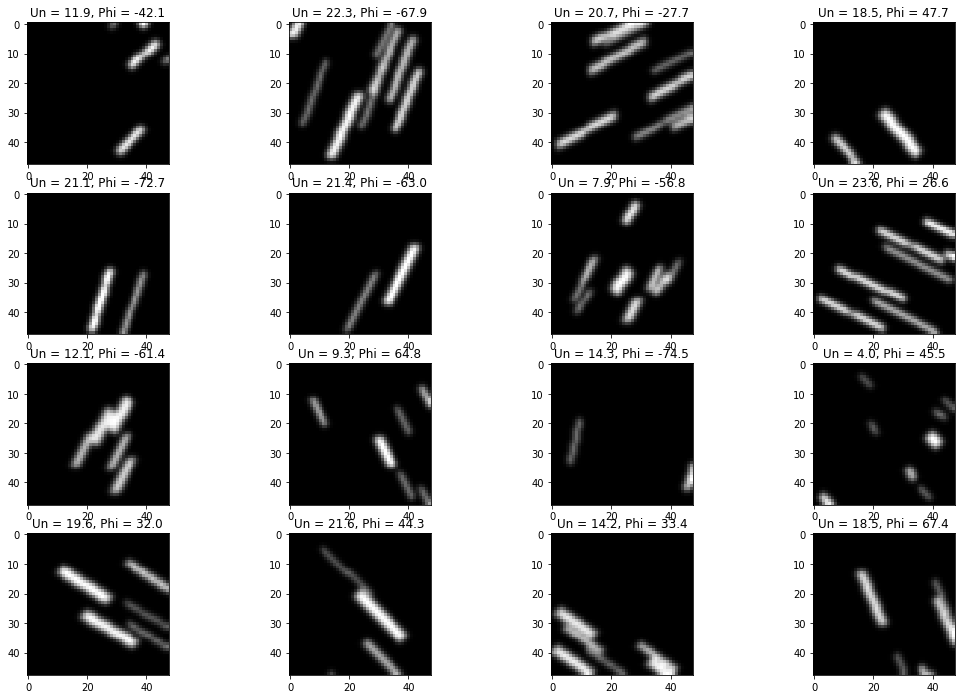

In [3]:
h5f = h5py.File('data/train_val_sets_n=1M.h5','r')

images = h5f['images'][()]
Un = h5f['Un'][()]
Phi = h5f['Phi'][()]
windowSize = h5f['windowSize'][()]

h5f.close()

trainImages, validationImages, trainData, validationData = \
    train_test_split(images, np.column_stack((Un, Phi)), test_size=0.25, random_state=my_seed, shuffle = False)

images = []

indices = random.randint(0, len(trainImages), 16)

fig = plt.figure()
for i in range(indices.size):
    ax = fig.add_subplot(4, 4, i + 1)
    plt.gray()
    plt.imshow(trainImages[indices[i],0,:,:])
    ax.set_title("Un = %.1f, Phi = %.1f" % (trainData[indices[i],0], trainData[indices[i],1]))
    
fig.set_size_inches(np.array(fig.get_size_inches()) * 3)
plt.show()

Preprocess data

((750000, 2), (250000, 2))


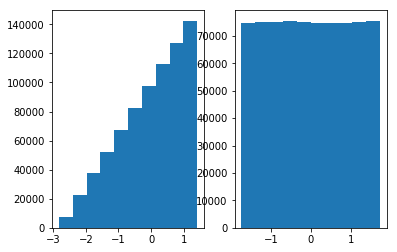

In [4]:
scaler = StandardScaler()
trainDataUnit = scaler.fit_transform(trainData)
validationDataUnit = scaler.transform(validationData)

print((trainDataUnit.shape, validationDataUnit.shape))

fig = plt.figure()
ax = fig.add_subplot(1,2,1)
plt.hist(trainDataUnit[:,0]);
ax = fig.add_subplot(1,2,2)
plt.hist(trainDataUnit[:,1]);

## Creating and training of a CNN

Define some global settings

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


Load network architecture we will use

In [6]:
from CNN_architectures import StreaksCNN

Convert data into pytorch compatible format

In [7]:
params = {'batch_size': 192,
          'shuffle': True,
          'num_workers': 0}

xtrain = torch.from_numpy(trainImages / 255.).type(torch.FloatTensor)
ytrain = torch.from_numpy(trainDataUnit).type(torch.FloatTensor)

train_dataset = TensorDataset(xtrain, ytrain)
train_loader = DataLoader(train_dataset, **params)

#for batch_idx, (x, y) in enumerate(train_loader):
#    print(x.shape, y.shape)

xvalidation = torch.from_numpy(validationImages / 255.).type(torch.FloatTensor)
yvalidation = torch.from_numpy(validationDataUnit).type(torch.FloatTensor)

validation_dataset = TensorDataset(xvalidation, yvalidation)
validation_loader = DataLoader(validation_dataset, **params)

print(len(train_dataset), len(validation_dataset))

750000 250000


Perform training

In [16]:
learning_rate = 1e-3

net = StreaksCNN(winSz = windowSize, filtSz = 5, convPad = 2)
net.to(device)
loss = torch.nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', \
                                                 factor = 0.5, patience = 7, \
                                                 min_lr = 1e-5, verbose = True, \
                                                 threshold = 1e-3)

n_epochs = 150
n_batches = len(train_loader)

# Time for printing
training_start_time = time.time()

train_loss_log = np.zeros(n_epochs)
validation_loss_log = np.zeros(n_epochs)

# Loop for n_epochs
for epoch in range(n_epochs):
    print_every = n_batches // 5
    start_time = time.time()
    total_train_loss = 0
        
    net.train()
    for i, data in enumerate(train_loader, 0):
        # Get inputs
        inputs, labels = data
            
        # Wrap them in a Variable object
        #inputs, labels = Variable(inputs), Variable(labels)
        inputs, labels = inputs.to(device), labels.to(device)
                
        # Set the parameter gradients to zero
        optimizer.zero_grad()
            
        # Forward pass, backward pass, optimize
        outputs = net(inputs)
        
        loss_size = loss(outputs, labels)
        loss_size.backward()
        optimizer.step()
            
        total_train_loss += loss_size.item()

        # Reset time
        start_time = time.time()
    
    # At the end of the epoch, do a pass on the validation set
    net.eval()
    total_val_loss = 0
    for inputs, labels in validation_loader:
        # Wrap tensors in Variables
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        val_outputs = net(inputs)
        val_loss_size = loss(val_outputs, labels)
        total_val_loss += val_loss_size.item()
        
    scheduler.step(total_val_loss)
    sys.stdout.flush()
    
    train_loss_log[epoch] = np.sqrt(total_train_loss / len(train_dataset))
    validation_loss_log[epoch] = np.sqrt(total_val_loss / len(validation_dataset))
    
    print("Epoch {:}. Train RMSE = {:.4f}, Validation RMSE = {:.4f}".format(epoch, train_loss_log[epoch], validation_loss_log[epoch]))

print("Training finished, took {:.4f}s".format(time.time() - training_start_time))

Epoch 0. Train RMSE = 0.4491, Validation RMSE = 0.7351
Epoch 1. Train RMSE = 0.3596, Validation RMSE = 0.3161
Epoch 2. Train RMSE = 0.3407, Validation RMSE = 0.2893
Epoch 3. Train RMSE = 0.3312, Validation RMSE = 0.2768
Epoch 4. Train RMSE = 0.3242, Validation RMSE = 0.2901
Epoch 5. Train RMSE = 0.3189, Validation RMSE = 0.2815
Epoch 6. Train RMSE = 0.3150, Validation RMSE = 0.2871
Epoch 7. Train RMSE = 0.3125, Validation RMSE = 0.2749
Epoch 8. Train RMSE = 0.3093, Validation RMSE = 0.2687
Epoch 9. Train RMSE = 0.3074, Validation RMSE = 0.2714
Epoch 10. Train RMSE = 0.3050, Validation RMSE = 0.2707
Epoch 11. Train RMSE = 0.3038, Validation RMSE = 0.2654
Epoch 12. Train RMSE = 0.3014, Validation RMSE = 0.2746
Epoch 13. Train RMSE = 0.3004, Validation RMSE = 0.2726
Epoch 14. Train RMSE = 0.2997, Validation RMSE = 0.2740
Epoch 15. Train RMSE = 0.2990, Validation RMSE = 0.2702
Epoch 16. Train RMSE = 0.2979, Validation RMSE = 0.2676
Epoch 17. Train RMSE = 0.2969, Validation RMSE = 0.2706
Ep

Once the network is trained, let us display some learning statistics and model information

Text(0, 0.5, 'RMSE')

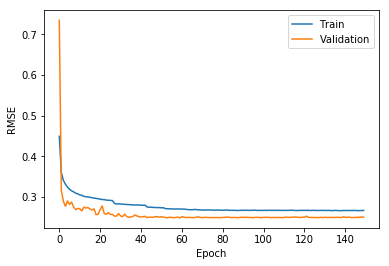

In [17]:
fig = plt.figure()
plt.plot(train_loss_log, '')
plt.plot(validation_loss_log)
plt.legend(('Train', 'Validation'))
plt.xlabel('Epoch')
plt.ylabel('RMSE')

Print model summary

In [18]:
print(net)

StreaksCNN(
  (cnn_part): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): ReLU()
    (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (13): ReLU()
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout2d(p=0.2)
  (fc1): Linear(in_features=1152, out_feat

Apply final network to the validation data set and check accuracy on Un and phi independently

In [19]:
params = {'batch_size': 192,
          'shuffle': False,
          'num_workers': 0}

test_loader = DataLoader(validation_dataset, **params)

ypredicted = np.empty(shape=(0,2))

net.eval()
for inputs, outputs in test_loader:
    # Wrap tensors in Variables
    inputs, outputs = inputs.to(device), outputs.to(device)
            
    # Forward pass
    val_outputs = net(inputs)
    
    if 'cuda' in device.type:
        val_outputs = val_outputs.cpu()
    
    ypredicted = np.concatenate((ypredicted, val_outputs.data.numpy()))
    
ypredicted = scaler.inverse_transform(ypredicted)
yresiduals = ypredicted - validationData
yrmse = np.sqrt(np.mean(yresiduals**2, axis = 0))

print('RMSE on Un = ', yrmse[0], ', RMSE on phi = ', yrmse[1])

thrNorm = 2;
thrPhi = 18; 
numCorrectNorm = np.sum(np.abs(yresiduals[:,0]) < thrNorm)
numCorrectPhi = np.sum(np.abs(yresiduals[:,1]) < thrPhi)

accuracy = np.array([numCorrectNorm, numCorrectPhi])/len(yresiduals)
print(accuracy)

RMSE on Un =  1.0568375586212455 , RMSE on phi =  8.6476552277374
[0.953912 0.98186 ]


Save trained network and all additional training data

In [20]:
file_net = 'network_n=1M'

torch.save(net.state_dict(), ('networks/%s.pytorch' % file_net))

h5f = h5py.File(('networks/%s_data.h5' % file_net), 'w')
h5f.create_dataset('RMSE', data=yrmse, compression="gzip", compression_opts=6)
#h5f.create_dataset('trainImages', data=trainImages, compression="gzip", compression_opts=6)
h5f.create_dataset('validationImages', data=validationImages, compression="gzip", compression_opts=6)
#h5f.create_dataset('trainData', data=trainData)
h5f.create_dataset('validationData', data=validationData)
h5f.create_dataset('scale', data=scaler.scale_)
h5f.create_dataset('mean', data=scaler.mean_)
h5f.create_dataset('rmse_training', data=train_loss_log)
h5f.create_dataset('rmse_validation', data=validation_loss_log)
h5f.create_dataset('windowSize', data=windowSize)

h5f.close()